<a href="https://colab.research.google.com/github/andreaaraldo/drt-accessibility/blob/main/DRT-Tuesday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/graph.py
!wget https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/ptline.py
!wget https://github.com/andreaaraldo/drt-accessibility/blob/main/OpenStreetMap_Montreal.png?raw=true -O OpenStreetMap_Montreal.png

--2024-01-23 11:34:11--  https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/graph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9206 (9.0K) [text/plain]
Saving to: ‘graph.py.4’

graph.py.4          100%[===================>]   8.99K  --.-KB/s    in 0s      

2024-01-23 11:34:11 (42.2 MB/s) - ‘graph.py.4’ saved [9206/9206]

--2024-01-23 11:34:11--  https://raw.githubusercontent.com/andreaaraldo/drt-accessibility/main/ptline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098 (1.1K) [text/plain]
Saving to

In [2]:
import numpy as np
import networkx as nx
import sys
import random
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mping
import math

import graph
import ptline
import time

t_begin = time.time()

## Parameters

In [3]:
#aa: I moved here these parameters
# Parameters
debug = False # prints some messages useful to debug
assign_iterations = 4
trip_generation_rate = 0.008
pt_mode_share = 0.124
walk_speed = 3.5 #Km/h
v_bus = 30 # km/h
tau_s = 15/3600 # (in hours) time spent per pickup or dropoff
tau_T = 180/3600  # (in hours) dwell time. Time that a bus spends doing nothing at the
                  # end of each cycle

## 0. Load data ( Montreal use case )

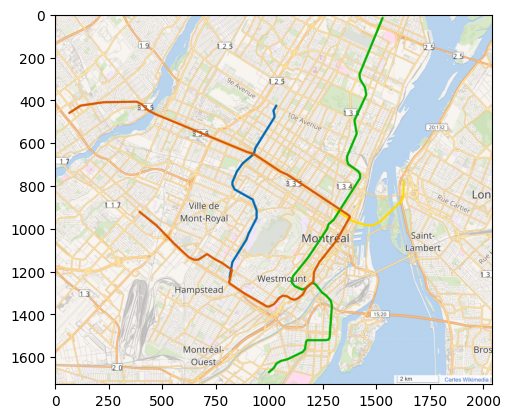

In [4]:
I = mping.imread('OpenStreetMap_Montreal.png')
plt.imshow(I)
plt.show()

In [5]:
metro_stations_line_1 = [[14.05154836,  2.22004959],
       [15.13790836,  2.73616959],
       [16.40851836,  3.37988959],
       [17.47221836,  3.64729959],
       [18.01638836,  3.91712959],
       [18.10515836,  4.92571959],
       [17.76756836,  5.73993959],
       [16.57472836,  6.18477958],
       [15.95520836,  7.01626959],
       [16.67042836,  7.62148959],
       [17.17587836,  8.20547959],
       [17.52006836,  8.55582959],
       [17.86689836,  9.01298959],
       [18.25563836,  9.32241959],
       [18.67550836,  9.78364959],
       [19.25245836, 10.18019959],
       [19.59719836, 10.74746959],
       [19.65296836, 11.79422959],
       [19.43340836, 12.69765959],
       [19.74151836, 13.26030959],
       [19.70125836, 14.01446959],
       [20.16622836, 14.78435959],
       [20.18756836, 15.73013959],
       [20.25642836, 16.56151959],
       [20.64989836, 17.20974959],
       [21.07493836, 17.94619959],
       [21.50316836, 18.73170959]]
len(metro_stations_line_1)

27

In [6]:
metro_stations_line_2 = [[ 0.92403836, 14.53674959],
       [ 2.36173836, 14.78556959],
       [ 5.34042836, 14.70845959],
       [ 6.89560836, 14.18925959],
       [ 8.23265836, 13.69205959],
       [10.09880836, 13.17780959],
       [11.23037836, 12.85979959],
       [12.86530836, 12.40494959],
       [13.87884836, 11.99772959],
       [14.63872836, 11.59941959],
       [15.83475836, 11.12267959],
       [16.37903836, 10.85119959],
       [17.78065836, 10.20538959],
       [18.67891836,  9.78210959],
       [19.16896836,  9.21395959],
       [18.84424836,  8.80706959],
       [18.45154836,  8.32185959],
       [17.99867836,  7.89824959],
       [17.57638836,  7.53073959],
       [16.94080836,  6.88745959],
       [16.57472836,  6.18477959],
       [15.86533836,  5.61398959],
       [13.98686836,  5.25989959],
       [12.21421836,  5.87677959],
       [11.34422836,  6.50641959],
       [10.75352836,  7.26794959],
       [10.18592836,  7.51962959],
       [ 8.58344836,  7.51951959],
       [ 7.62534836,  8.11439959],
       [ 6.16696836,  9.12716959],
       [ 5.29125836,  9.67485959]]
len(metro_stations_line_2)

31

In [7]:
metro_stations_line_3 = [[18.68309836,  9.77979959],
       [21.75055836,  9.47597959],
       [22.96374836, 10.84668959]]
len(metro_stations_line_3)

3

In [8]:
metro_stations_line_4 = [[11.34125836,  6.50311959],
       [11.82206836,  7.76184959],
       [12.44763836,  8.45946959],
       [12.98014836,  9.19998959],
       [12.74716836, 10.34948959],
       [11.83625836, 10.68916959],
       [11.69303836, 11.42825959],
       [12.20849836, 12.00685959],
       [12.87036836, 12.41550959],
       [13.50286836, 13.25161959],
       [14.17584836, 14.00676959],
       [14.39430836, 14.66038959]]
len(metro_stations_line_4)

12

In [9]:
nb_of_staions_each_metro_line = [ len(metro_stations_line_1),len(metro_stations_line_2),len(metro_stations_line_3),len(metro_stations_line_4) ]
print(nb_of_staions_each_metro_line)

cumsum_nb_of_staions_each_metro_line = np.cumsum( nb_of_staions_each_metro_line )
print(cumsum_nb_of_staions_each_metro_line)

[27, 31, 3, 12]
[27 58 61 73]


In [10]:
connection_between_lines = [[7, 47], [14, 40], [14, 58], [34, 69], [40, 58], [51, 61]]

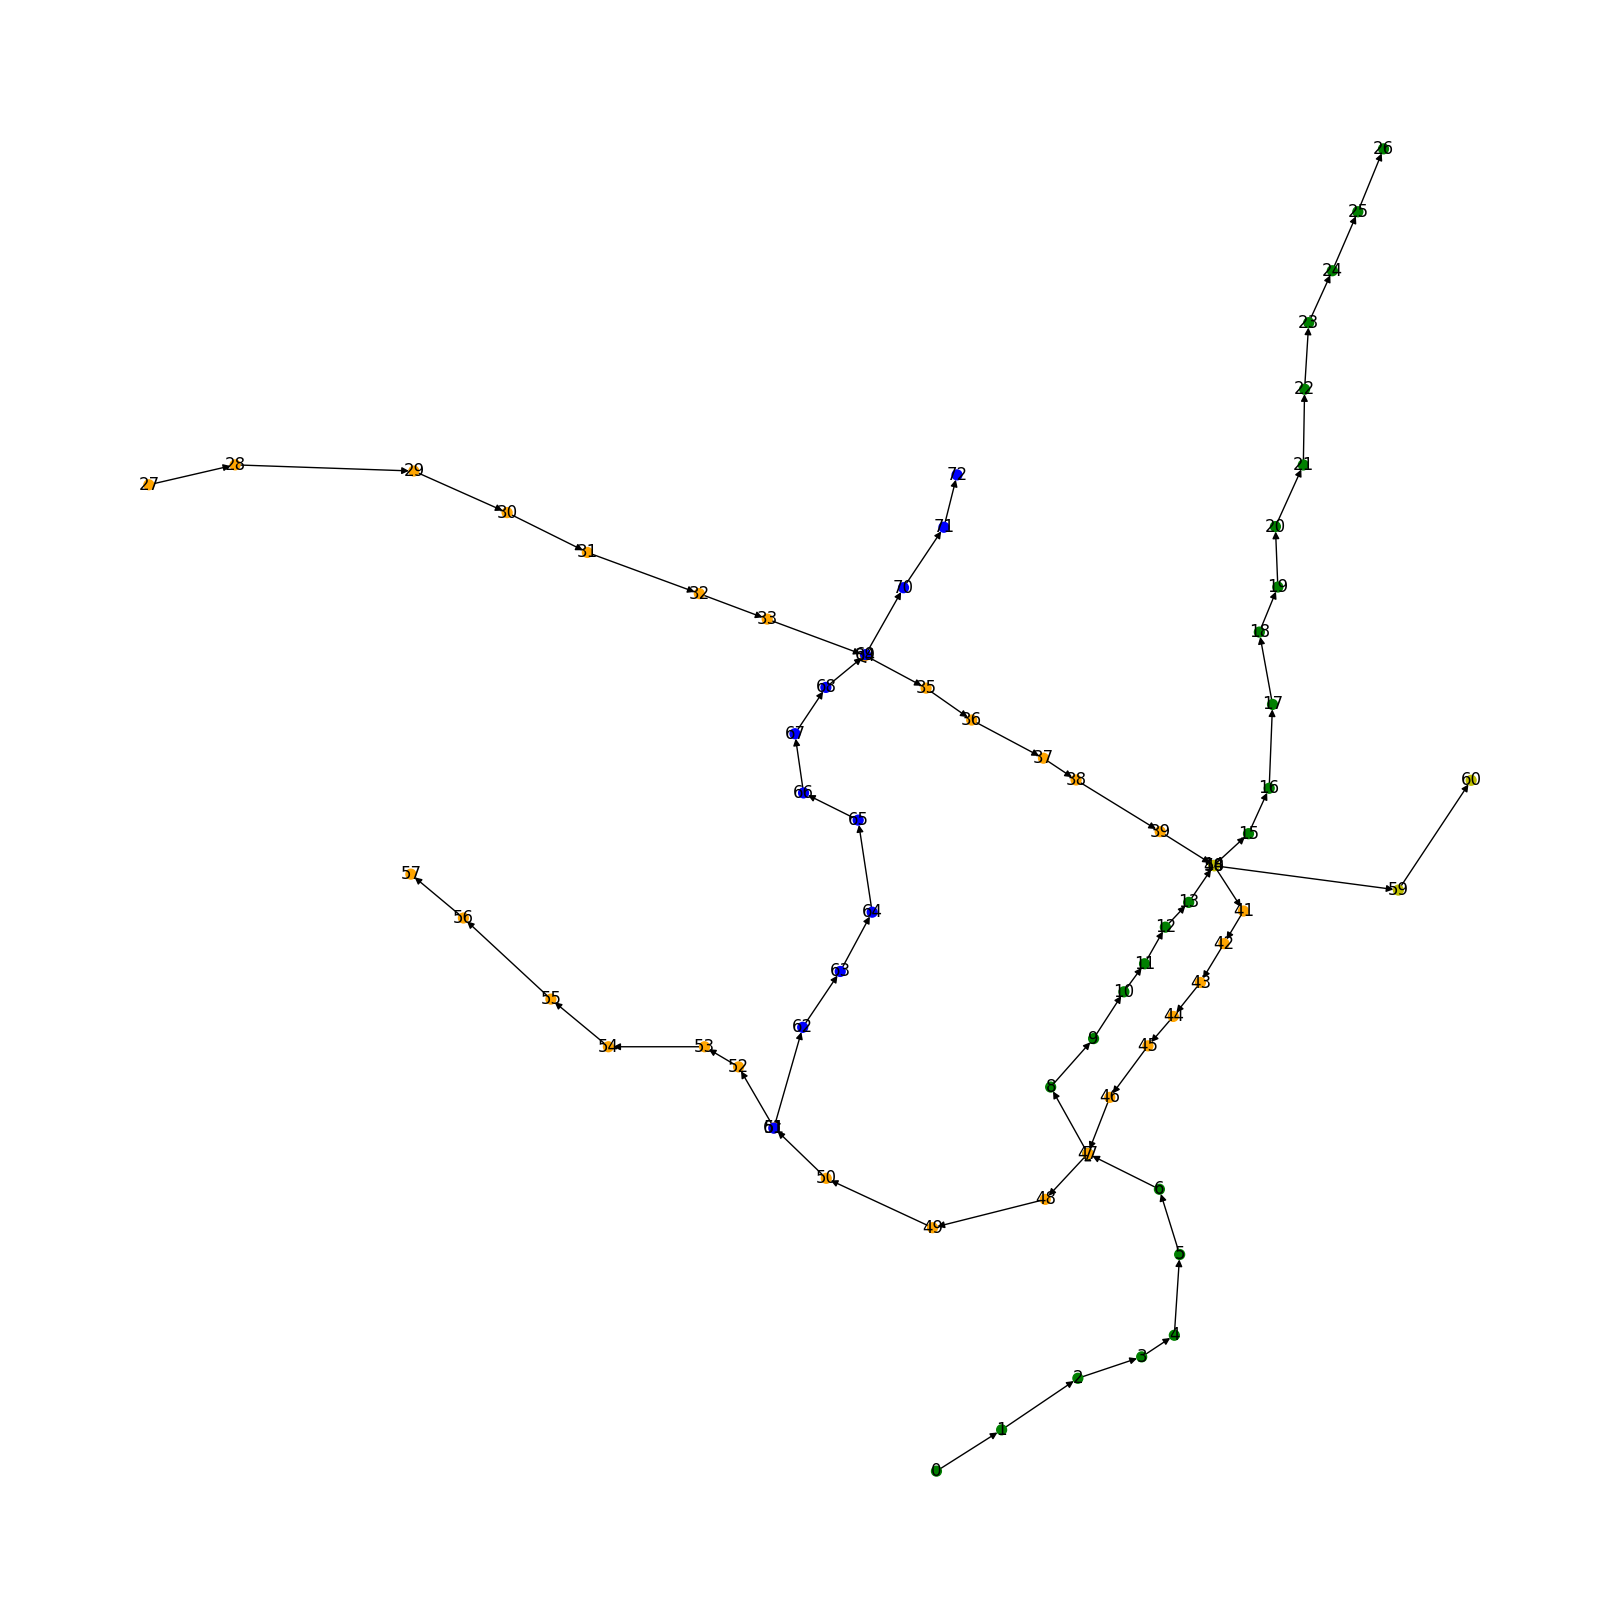

In [11]:
g = nx.DiGraph()

all_stations = metro_stations_line_1 +metro_stations_line_2 +metro_stations_line_3 +metro_stations_line_4
nb_of_all_stations = len(all_stations)


g.add_nodes_from([i for i in range(nb_of_all_stations)])

all_edges = [(i,i+1) for i in range(nb_of_all_stations) if i!= 26 and i!= 57 and i!= 60 and i!= 72] + connection_between_lines
g.add_edges_from(all_edges)

node_color=["green" for i in range(len(metro_stations_line_1))]+["orange" for i in range(len(metro_stations_line_2))]+["y" for i in range(len(metro_stations_line_3))]+["blue" for i in range(len(metro_stations_line_4))]
node_size=[50 for i in range(73)]

fig=plt.figure(figsize=(16,16))
nx.draw(g, all_stations, with_labels=True,node_color=node_color, node_size = node_size)
plt.show()

In [12]:
# metro dwell time for each station (hour)
dwell_time_1 = list(np.array([1,2,1,1,2,1,2,2,1,2,1,1,1,1,1,1,2,2,1,1,2,1,2,1,1,3])/60) #3 min/60 = 1/20 h

dwell_time_2 = list(np.array([1,3,2,1,2,1,2,1,2,1,5,1,1,1,2,2,1,2,1,2,2,2,1,2,1,1,1,2,1,2])/60)

dwell_time_3 = list(np.array([2,4])/60)

dwell_time_4 = list(np.array([1,1,2,3,2,1,1,1,2,1,2])/60)

In [13]:
node_ids_line_1 = [i for i in range(cumsum_nb_of_staions_each_metro_line[0])]
node_ids_line_2 = [i for i in range(cumsum_nb_of_staions_each_metro_line[0],cumsum_nb_of_staions_each_metro_line[1])]
node_ids_line_3 = [i for i in range(cumsum_nb_of_staions_each_metro_line[1],cumsum_nb_of_staions_each_metro_line[2])]
node_ids_line_4 = [i for i in range(cumsum_nb_of_staions_each_metro_line[2],cumsum_nb_of_staions_each_metro_line[3])]
list_waiting_time = [7/60,7/60,7.5/60,7.5/60] # 7.5 mins/60 = 0.125 hour
#create bus_line
metro_line_1 = ptline.PTline( 'Angrignon--Honoré-Beaugrand',list_waiting_time[0],
                                 node_ids_line_1,
                                 dict( zip(node_ids_line_1, metro_stations_line_1)),
                                 dwell_time_1 )


metro_line_2 = ptline.PTline( 'Côte-Vert--Montmorency',list_waiting_time[1],
                                 node_ids_line_2,
                                 dict( zip(node_ids_line_2, metro_stations_line_2)),
                                 dwell_time_2 )

metro_line_3 = ptline.PTline( 'Berri–UQAM--Longueuil–Université-de-Sherbrooke',list_waiting_time[2],
                                 node_ids_line_3,
                                 dict( zip(node_ids_line_3, metro_stations_line_3)),
                                 dwell_time_3 )

metro_line_4 = ptline.PTline( 'Snowdon--Saint-Michel',list_waiting_time[3],
                                 node_ids_line_4,
                                 dict( zip(node_ids_line_4, metro_stations_line_4)),
                                 dwell_time_4 )

In [14]:
#create Public transit graph
g  = graph.Graph( list_waiting_time )

#add each bus_line
g.add_metro_line(metro_line_1)
g.add_metro_line(metro_line_2)
g.add_metro_line(metro_line_3)
g.add_metro_line(metro_line_4)

#add transfer station and time  (7,47,list_waiting_time[1]+2/60) means from line_1 (station 7) tansfer to line_2 (station 47),
#                                the time cost is average waiting time of line 2 + 2 mins of walking
connection_and_transfer_time = [(7, 47,list_waiting_time[1]+2/60), (47, 7,list_waiting_time[0]+2/60),
                                (14, 40,list_waiting_time[1]+2/60),(40, 14,list_waiting_time[0]+2/60),
                                (14, 58,list_waiting_time[2]+2/60),(58, 14,list_waiting_time[0]+2/60),
                                (34, 69,list_waiting_time[3]+2/60),(69, 34,list_waiting_time[1]+2/60),
                                (40, 58,list_waiting_time[2]+2/60),(58, 40,list_waiting_time[1]+2/60),
                                (51, 61,list_waiting_time[3]+2/60),(61, 51,list_waiting_time[1]+2/60)]

g.add_connection(connection_and_transfer_time)
#np.save( 'test_set.npy',graph_dic )

In [15]:
g.add_centroids()

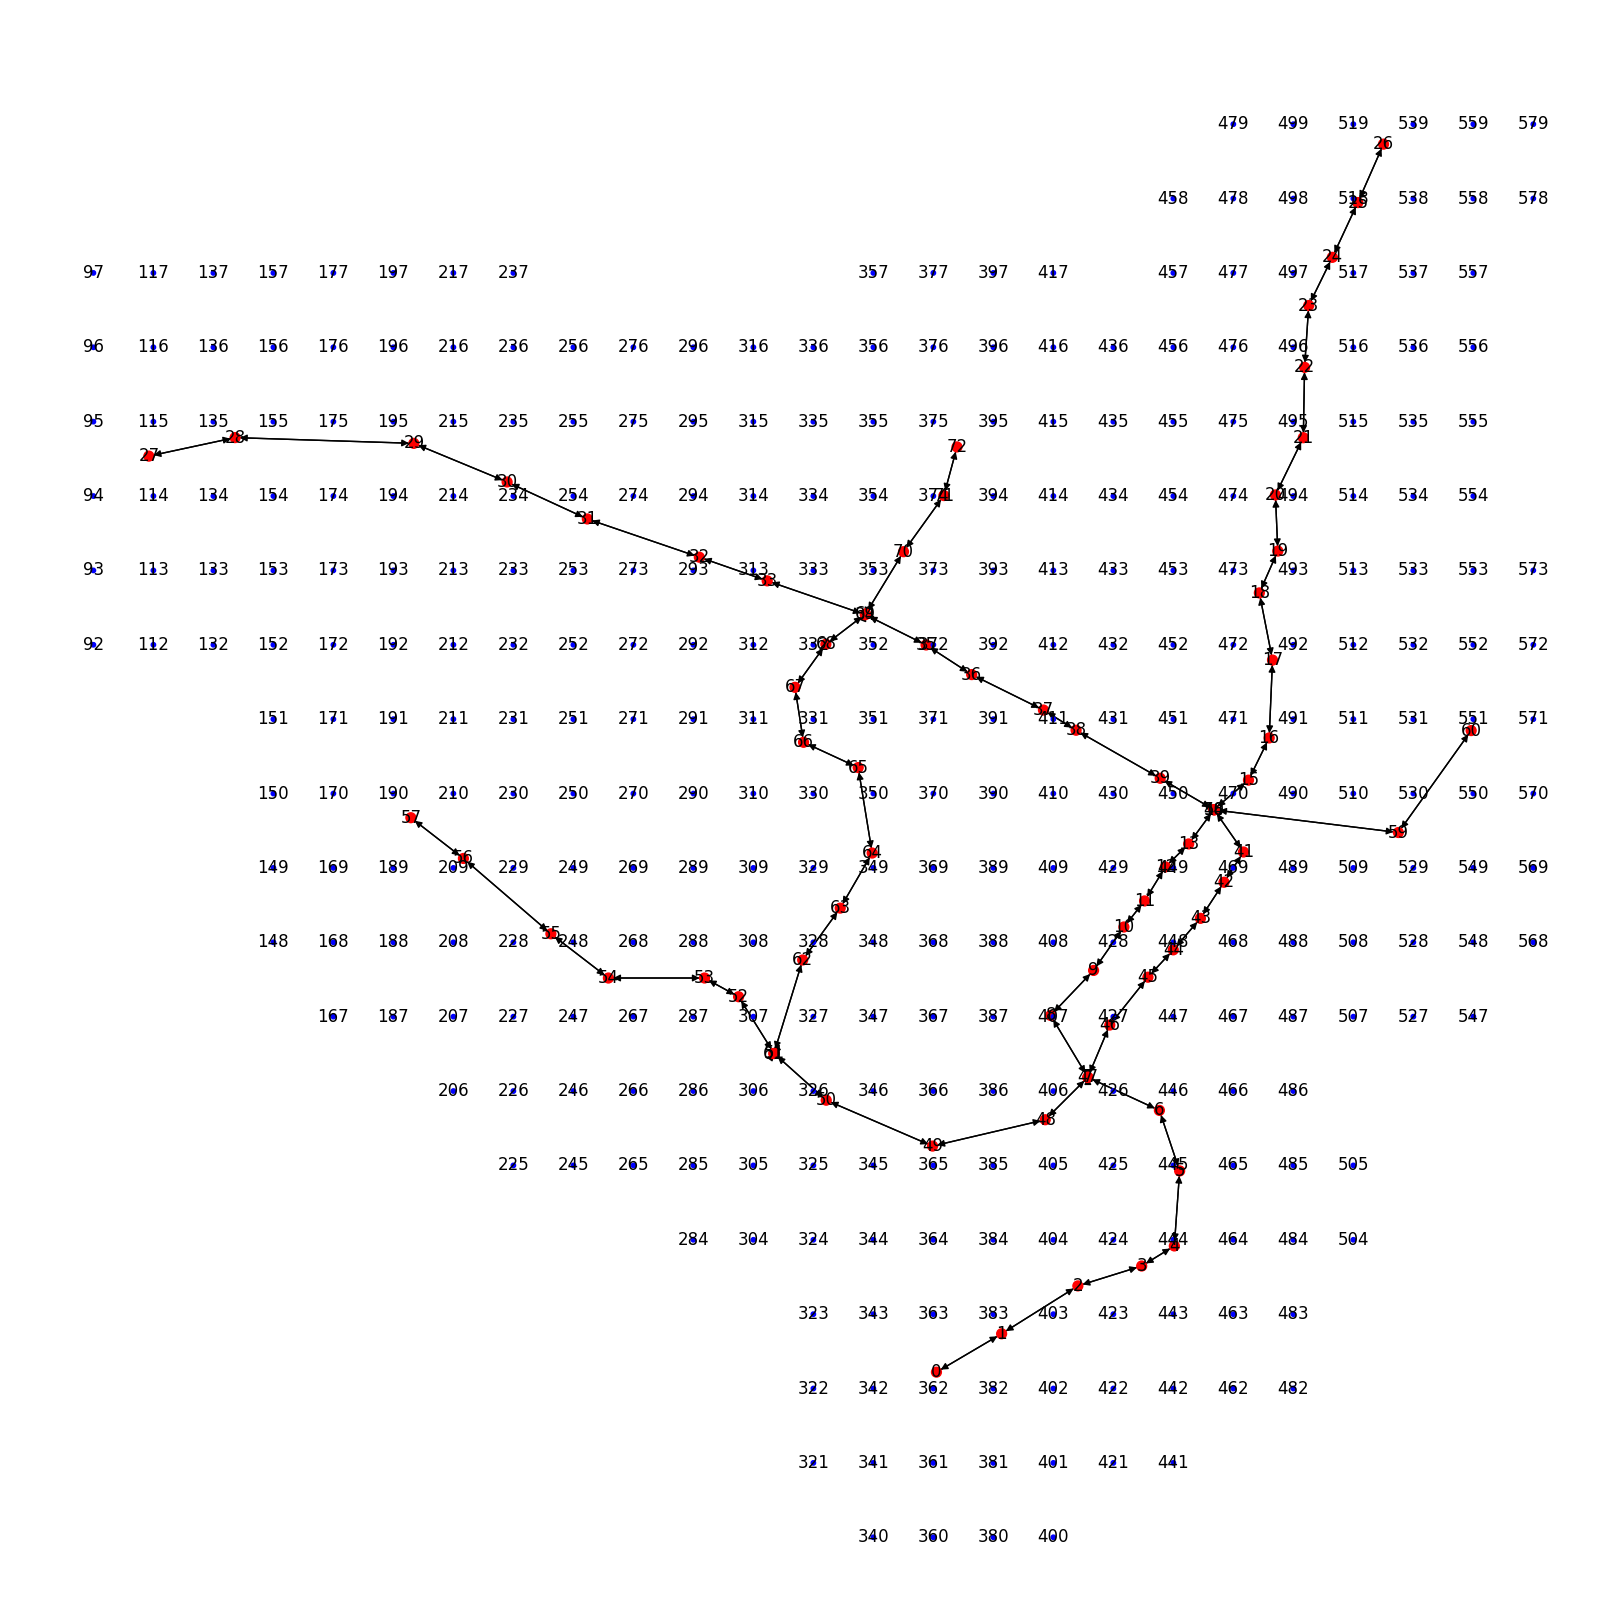

In [16]:
g.show()

In [17]:
g.add_edge_between_centroids()

In [18]:
#g.show()

In [19]:
g.add_edge_between_centroid_and_station()

In [20]:
def build_accessibility_matrix(g):
  g.get_acc()
  leftmost=float('inf')
  rightmost=-float('inf')
  bottommost=float('inf')
  upmost=-float('inf')
  for pos in g.centroid_pos:
    leftmost = min(leftmost, pos[0])
    rightmost = max(rightmost, pos[0])
    bottommost = min(bottommost, pos[1])
    upmost = max(upmost, pos[1])

  rows = upmost-bottommost+1
  cols = rightmost-leftmost+1
  acc_matr = np.array([([float('nan')]*cols) for i in range(rows)])
  centr_id_matr = np.array([([float('nan')]*cols) for i in range(rows)])

  for centr in g.centroid_node:
    acc = g.centroid_to_acc[centr]
    pos = g.centroid_to_pos[centr]
    centr_id_matr[ upmost-pos[1], pos[0] ]=centr
    acc_matr[ upmost-pos[1], pos[0] ]=acc

  return centr_id_matr, acc_matr



In [21]:

t_0 = time.time()
centr_id_matr, acc_matr_init = build_accessibility_matrix(g)
t_1 = time.time()
print(f'Time to compute accessibility: {t_1 - t_0:.0f} seconds')


Time to compute accessibility: 9 seconds


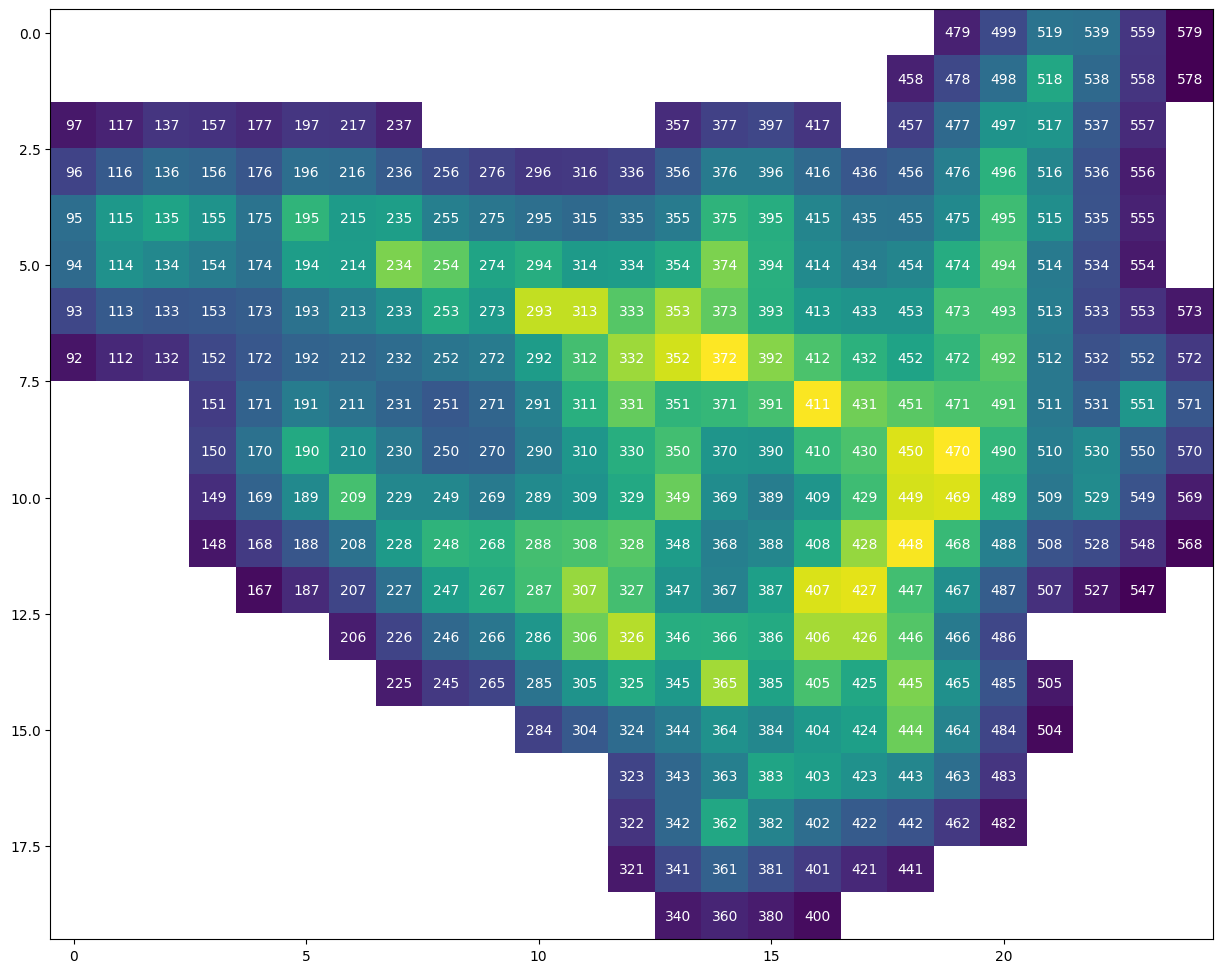

In [22]:
def plot_acc(centr_id_matr, acc_matr):
  fig, ax = plt.subplots(figsize=(15, 15))
  im = ax.imshow(acc_matr)

  for i in range(centr_id_matr.shape[0]):
    for j in range(centr_id_matr.shape[1]):
        text = ax.text(j, i, f'{centr_id_matr[i,j]:.0f}',
                       ha="center", va="center", color="w")

plot_acc(centr_id_matr, acc_matr_init)

In [23]:
centroid_polulation = g.centroid_polulation
total_polulation = g.total_polulation
print(total_polulation)

1180140


## 2. DRT allocation function definitions

In [24]:
def find_s1(area,g):
  # Find point "s_1" (see the paper) that is the first point visited by the
  # DRT bus when it enters the area

  s1 = (g.centroid_to_pos[area[4]] + g.centroid_to_pos[area[5]])/2 + np.array([0.5,0])
  return s1

In [25]:
def findClosestStation(area,g):
    DRT_s_1 = find_s1(area,g)
    distance_station_area_list = []
    for i in g.metro_node:
        metro_pos_i = np.array(g.metro_pos[i])
        distance_station_area_list.append( np.linalg.norm( metro_pos_i - DRT_s_1 ) )

    closest_station = np.argmin( distance_station_area_list )
    return closest_station

In [26]:
def calculatePho(metro_station_s_A,centroid_i,g, \
        all_pairs_shortest_paht_lengths, all_pair_shortest_paths):
    """
    Calculate what proportion of demands go from centroid_i to somewhere else via metro_station_s_A.
    """

    beta = 0.12
    dest_centroids = []

    #aa: I replaced the previous for-loop with this{
    shortest_paths_from_i_lengths = all_pairs_shortest_paht_lengths.get(centroid_i)
    a = []
    for dest in list(shortest_paths_from_i_lengths.keys()):
       if dest in g.centroid_node and dest != centroid_i:
           dest_centroids.append( dest )
           time_to_dest = shortest_paths_from_i_lengths[dest]
           impedance = np.exp( - beta * time_to_dest  )
           a.append( centroid_polulation[dest] * impedance)
    a = np.array(a)
    # a is the vector of all importances of all destinations
    ##aa: }

    b = a/np.sum(a)
    c = {}
    for k in range(len(b)):
        dest_centro_id = dest_centroids[k]
        c[dest_centro_id] = b[k]  # if dest_centroids[k] = j, b[k] represents
                            # the proportion of
                            # demand that  go from centroid_i centroid j.

    # vector c has, per each destination, the proportion of demand generated
    # from i that go toward c
    pho = 0.0
    for dest_centroid_id in c:
      if (metro_station_s_A in all_pair_shortest_paths[centroid_i][dest_centroid_id]):
        pho = pho + c[dest_centroid_id]

    t_1 = time.time()
    return pho

In [27]:
from sympy import solve, symbols


def getHx(n_bus,pho,distance_station_area):
    """
    Solve the system of equations to find the headway of the DRT into an area
    """
    l = 1      #1 km
    h = symbols('h')

    if (not np.isscalar(pho)):
      raise Exception("pho is not a scaler. pho=", pho,". Its type is ", type(pho) )


    h_x = 0
    cycle_time = 0
    #TODO: for the moment, we assume that the DRT demand is symmetric, i.e.,
    #  the demand out (pax using DRT as first mile) = demand in (pax using DRT in their last mile).
    #  This assumption might not be true and should be removed
    h_x = solve( (2*distance_station_area + 6*l*(2*pho*l*l*h)/(2*pho*l*l*h+1)+(2*pho*l*l*h)*l/3+l*4/3)/v_bus + tau_s*(2*pho*l*l*h) + tau_T - n_bus*h  , h)

    print()

    #TODO: Take the smallest postive solution instead of what we do now
    if len(h_x) == 0:
        print('bug h_x no solution!') #TODO: We should rise an exception instead
    elif len(h_x) == 1:
        hx = float(h_x[0])
        #aa: there was a mistake in the line below. the last variable you use
        # in the equation is h and not hx. This was making cycle time be a
        # "symbol", instead of a simple variable, which was messing the entire
        # code. This version of the code is corrected. Notice that I avoid to
        # repeat the same equation again. I only wrote the equation related to
        # cycle time once, at the end of this if-elif-else block
        #cycle_time =  n_bus*hx +  tau_T + tau_s*(2*pho*l*l*h)


        #aa: Moreover, there was also a mistake in the line below (that I now removed).
        # You were returning cycle_length.
        # Compare with meld my getHx and your getHx
        # to get the mistake
    else:
        #print('2 solutions',float(h_x[0]),float(h_x[1]))
        #aa: why we take the max among the two roots. Should not we take
        # the minimum among the positive roots?
        hx = min( float(h_x[0]),float(h_x[1]) )
        if (hx <= 0):
          hx = max( float(h_x[0]),float(h_x[1]) )

    pudos = 2*pho*l*l*hx #number of pickups and dropoffs performed by each bus in a cycle
    cycle_time =  n_bus*hx +  tau_T + tau_s*pudos

    #aa: The following exception helped me in findig the errors above. It is a
    # good idea to keep such Exception, to help us in the future. So, please keep
    # these "raise Exception(..)" here.
    if (not np.isscalar(hx)):
      raise Exception("hx is not a scaler. hx=", hx,\
                      ". Its type is ", type(hx) )

    if (not np.isscalar(cycle_time)):
      raise Exception("cycle_time is not a scaler. cycle_time=", cycle_time,\
                      ". Its type is ", type(cycle_time) )
    #aa: I also return the pudos
    return hx, cycle_time, pudos

In [28]:
#aa: I renamed "time_alpha" into remaining_fraction_of_cycle
def ingress_or_egress_time(hx,remaining_fraction_of_cycle,n_bus,distance_station_area):
    """
    remaining_fraction_of_cycle: It is a scalar representing the fraction of cycle that is still
              to be done when the DRT bus is at a certain centroid
    """
    # Find ingress_or/egress time for a tile
    #aa: Here you had a hardcoded v_bus=25, which I now removed. I added a
    # constant at the beginning of the notebook
    t = hx/2+ remaining_fraction_of_cycle*(hx*n_bus-2*distance_station_area/v_bus) \
            + distance_station_area/v_bus
    return t

In [29]:
def compute_fractions_of_remaining_cycle(list_num_services):
  total_area_demand = np.sum(list_num_services)
  #aa: I had to handle the case where no demand was present, as it
  # was raising an issue
  fractions_of_remaining_cycle = []
  if (total_area_demand == 0):
    for i in range(len(list_num_services)):
      fractions_of_remaining_cycle.append( ( len(list_num_services) - i) / len(list_num_services) )
  else:
    for i in range(len(list_num_services)):
      if i== len(list_num_services)-1:
        fractions_of_remaining_cycle.append( (list_num_services[i]/2) / total_area_demand )
      else:
        fractions_of_remaining_cycle.append( \
                (list_num_services[i]/2 + np.sum(list_num_services[i+1:])) \
                / total_area_demand )

  if (len(fractions_of_remaining_cycle) != len(list_num_services)):
    raise Exception("len(fraction_of_remaining_cycle)=",len(fractions_of_remaining_cycle),\
                    " and len(list_num_services)=",len(list_num_services),\
                    ". They must be equal instead")
  return fractions_of_remaining_cycle

In [30]:
def assignDRT(n_bus,area,g, assign_iterations):
    """
    area: is [list_of_tiles_belonging_to_an_area]
    Returns:minutes
      valid: if assignment is valid or not
      hx: headway (in hours)
      cycle_time: average time spent by each bus to serve the area (in hours)
    """
    if (assign_iterations <= 1):
      raise Exception ("assign_iterations should be at least 2. You instead ",\
                       "inputted assign_iterations==", assign_iterations)

    # Assign n_bus DRT buses to current worst area worst_.
    #aa: Here you had a hardcoded v_bus=25, which I now removed. I added a
    # constant at the beginning of the notebook
    metro_station = findClosestStation(area,g)
    #aa: I now print this information
    print("Closest metro station = ", metro_station)

    # Initialize parameters
    valid = False #aa: I added this
    hx = 0
    cycle_time = 0

    #aa: Why do you not have anymore the check for convergence, so as to exit from
    # traffic assignment earlier? This can save you a lot of time.

    DRT_s_1 = find_s1(area,g)
    metro_station_s_A_pos = np.array(g.metro_pos[metro_station])
    distance_station_area = np.linalg.norm( metro_station_s_A_pos - DRT_s_1 )

    #aa: renamed dict_centroid_walk to dict_centroid_walk_time
    dict_centroid_walk_time = {}
    for centroid in area:
        #aa: walk_speed is not hardcoded anymore
        dict_centroid_walk_time[centroid] = np.linalg.norm( metro_station_s_A_pos - g.centroid_to_pos[centroid] )/walk_speed
    # For the moment we have a maximum limit of assignment iterations because
    # we do all-or-nothing assingment, we in few cases causes the typical
    # instability and we could go on an infinite amount of time
    #TODO: improve traffic assignment
    demand_list_all_steps = list()
    centroids_choose_walking = []
    for i in range(assign_iterations):
        print("Assignment iteration",i)
        demand_total = 0.0 #aa: This line was, in your code, within the if
                      # I now moved it outiside the if. I think it is equivalent
                      # Do you agree with me?
        if i < assign_iterations-1:# calculate demand via shortest path
            demand_list = list()
            all_pairs_shortest_paht_lengths =  dict(nx.all_pairs_dijkstra_path_length(g.g))
            all_pair_shortest_paths = dict(nx.all_pairs_dijkstra_path(g.g) )
            for tile in area:
                demand_ = calculatePho(metro_station,tile,g,\
                          all_pairs_shortest_paht_lengths, all_pair_shortest_paths)*\
                          centroid_polulation[tile]*trip_generation_rate*pt_mode_share  # xxxx demands/km2/hour
                demand_total = demand_total + demand_
                demand_list.append( demand_ )
            # At this point demand_list contains all the travelers passing by
            # the stop associated to the area (either walking or using DRT)
        else:# the last itearation, calculate demand by taking average of the demands before
            #aa: It happens sometimes that demand_list_all_steps is empty as in all
            # previous iterations hx has always been 0. In this case, if we do not handle
            # separately, Python will raise an error when calculating
            # np.mean( np.array(demand_list_all_steps)
            if (not demand_list_all_steps):
              # demand_list_all_steps is empty. This means that in all previous
              # assignment iterations hx has always been 0.
              demand_total = 0
            else:
              demand_list = list( np.mean( np.array(demand_list_all_steps), axis=0 ) )
              demand_total = np.sum( demand_list )

        hx, cycle_time, pudos = getHx(n_bus,demand_total,distance_station_area)

        if (hx>0): #(otherwise do nothing as the allocation is invalid)
            # An area in map has centroids like in the following order:
                              #{1 3 5}
                              #{0 2 4}
            # the DRT bus runs a cycle by the following order:
            #           metro_station ->s_1-> 5-> 3-> 1-> 0-> 2-> 4 -> s_1 -> metro_station
            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            #aa: I now perform your old computation of alpha_0_list in a separate function
            # Please, conform to this in your code and check if my function implementation
            # is correct
            fractions_of_remaining_cycle = compute_fractions_of_remaining_cycle(phi_i_list)
            list_1 = [fractions_of_remaining_cycle[3],\
                    fractions_of_remaining_cycle[2],fractions_of_remaining_cycle[4],\
                    fractions_of_remaining_cycle[1],fractions_of_remaining_cycle[5],\
                    fractions_of_remaining_cycle[0]]

            # Update demand_list by comparing time cost of walking and DRT
            # We now remove from the demand the traveler flows for which it is
            # better to walk
            centroids_choose_walking = []
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                t_DRT = ingress_or_egress_time(hx,fraction_of_remaining_cycle,n_bus,distance_station_area)
                t_walking = dict_centroid_walk_time[j]
                if t_walking < t_DRT:
                    demand_list[tile] = 0.0
                    centroids_choose_walking.append( j )

            demand_list_all_steps.append( demand_list )

            #update new alpha from new demand_list

            phi_i_list = [demand_list[5],demand_list[3],demand_list[1],demand_list[0],demand_list[2],demand_list[4]]
            #aa: I now perform your old computation of alpha_0_list in a separate function
            # Please, conform to this in your code and check if my function implementation
            # is correct
            fractions_of_remaining_cycle = compute_fractions_of_remaining_cycle(phi_i_list)
            list_1 = [fractions_of_remaining_cycle[3],fractions_of_remaining_cycle[2],\
                    fractions_of_remaining_cycle[4],fractions_of_remaining_cycle[1],\
                    fractions_of_remaining_cycle[5],fractions_of_remaining_cycle[0]]

            #aa: I added this check for this strange phenomenon. Please add this check
            # also in your code and check if this happens. Set debug=True in the
            # parameters at the beginning of the notebook to activate this Warning
            if (demand_list.count(0) != len(centroids_choose_walking) and debug):
              print("Warning: the number of tiles in which the use of DRT is zero ",\
                    "should be equal to the number of centroids where it is faster to ",\
                    "walk than taking DRT. However: demand_list=",demand_list,\
                    " and centroids_choose_walking=",centroids_choose_walking,\
                    ". We are in iteration i=",i)

            #update ingress/egress time centroid <--> metro station
            for tile in range(len(area)):
                j = area[tile]
                fraction_of_remaining_cycle = list_1[tile]
                #print('centroid and time',j,  time_alpha*(hx*n_bus-2*distance_station_area/v_bus) + distance_station_area/v_bus)
                if j in centroids_choose_walking:
                    t_walking = dict_centroid_walk_time[j]
                    g.add_connection( [(j,metro_station, t_walking)] )
                    g.add_connection( [(metro_station,j, t_walking)] )
                else:
                    t_DRT = ingress_or_egress_time(hx,fraction_of_remaining_cycle,\
                                                   n_bus,distance_station_area)
                    g.add_connection( [(metro_station,j, t_DRT)] )



    #aa: Note that I am printing more information now. It is definitely useful
    # for my class. I don't know if it will be useful for you
    centroids_choosing_DRT = np.setdiff1d(np.array(area), np.array(centroids_choose_walking))
    if (debug):
      print("Centroids for which it is faster to use DRT than walking", centroids_choosing_DRT)

    if (demand_total==0 and i==assign_iterations-1):
          print ("Invalid allocation of DRT in this area: 0 users will use DRT in area ",\
              area,". This may be due to ",\
             "two factors:\n(i) the number of allocated buses is insufficient or ",\
             "\n(ii) centroids are so close to the associated station that it is always faster ",\
             "to walk to that stop than taking the DRT")
    elif(hx == 0):
      print("Invalid DRT allocation in this area")
    elif(hx*60.0 < 2.0):
      print("Error in area ", area,\
          ". Headway is ", hx*60," minutes. This is too short and difficult to ",\
          "operate in reality.\n Headway should be indeed at least ",\
          "2 minutes. Try to allocate less buses")
    else:
      valid = True
      print(f'headway hx {hx*60:.2f} min; cycle_time {cycle_time*60:.2f} min',\
            f'\nof which {(distance_station_area/v_bus)*60:.2f} min are for going to/from the metro stop;'
            f'\npickups and dropoffs per cycle  {pudos:.2f}')
      #aa: Please also return the average number of pickups and dropoffs served by
      # each DRT bus cycle
    return valid, hx, cycle_time

In [31]:
def create_area_from_id(area_id):
  area = [area_id, area_id+1, area_id+20, area_id+21, area_id+40, area_id+41]
  valid = True
  j = 0
  while valid and j<len(area):
    if not area[j] in g.centroid_node:
      print("area ",area," is not valid as centroid ",area[j],\
            " is outside the study area")
      valid = False
    j = j+1

  return valid, area

In [32]:
def allocateDRT(allocation):
  allocated_fleet = 0
  for area_id in allocation:
    valid,area = create_area_from_id(area_id)
    if (valid == True):
      num_buses = allocation[area_id]
      print ("\nAssigning ",num_buses," buses to area ", area)
      valid_assignment, hx, cycle_time = assignDRT(num_buses,area,g, \
                   assign_iterations=assign_iterations)
      if (valid_assignment):
        allocated_fleet = allocated_fleet + num_buses
    else:
      print("Area ", area_id, " will be ignored")

  print(f"Succesfully allocated a fleet of {allocated_fleet} buses")

## 3. The floor is yours!

It's now time to find your own allocation!

The allocation of the fleet of DRT buses should be in the form
`allocation={ area_id:num_buses, ...}`. An example is
```
allocation = {
    92 : 8,
    356: 8
}
```

An area is composed of 3x2 tiles. The id of an area corresponds to the id of the tile at the left-bottom corner of that area. For example, the id of the following area is `363`
```
   364  384  404
   363  383  403
```

You should deploy DRT where accessibility is low and you have enough population that can benefit from your service.

*Suggestion*. It is not worth allocating DRT close to PT stations. Indeed, it is very convenient for users therein to directly walk to PT stations. Therefore, to "convince them" to use DRT you should offer them a super-efficient service, which is competitive to walking, which would require you to deply too many DRT buses therein.

In [33]:
allocation = {
    92 : 8,
    356: 8,
    152: 7
 }

t_0 = time.time()
allocateDRT(allocation)
t_1 = time.time()
print("\n\nComputation time for assigning DRT: ",t_1-t_0)

print("Total computation time: ",t_1-t_begin)


Assigning  8  buses to area  [92, 93, 112, 113, 132, 133]
Closest metro station =  28
Assignment iteration 0

Assignment iteration 1

Assignment iteration 2

Assignment iteration 3

headway hx 2.94 min; cycle_time 26.91 min 
of which 4.58 min are for going to/from the metro stop;
pickups and dropoffs per cycle  1.55

Assigning  8  buses to area  [356, 357, 376, 377, 396, 397]
Closest metro station =  72
Assignment iteration 0

Assignment iteration 1

Assignment iteration 2

Assignment iteration 3

headway hx 2.97 min; cycle_time 27.21 min 
of which 4.29 min are for going to/from the metro stop;
pickups and dropoffs per cycle  1.85

Assigning  7  buses to area  [152, 153, 172, 173, 192, 193]
Closest metro station =  30
Assignment iteration 0

Assignment iteration 1

Assignment iteration 2

Assignment iteration 3

headway hx 3.24 min; cycle_time 26.05 min 
of which 4.38 min are for going to/from the metro stop;
pickups and dropoffs per cycle  1.40
Succesfully allocated a fleet of 23 bus

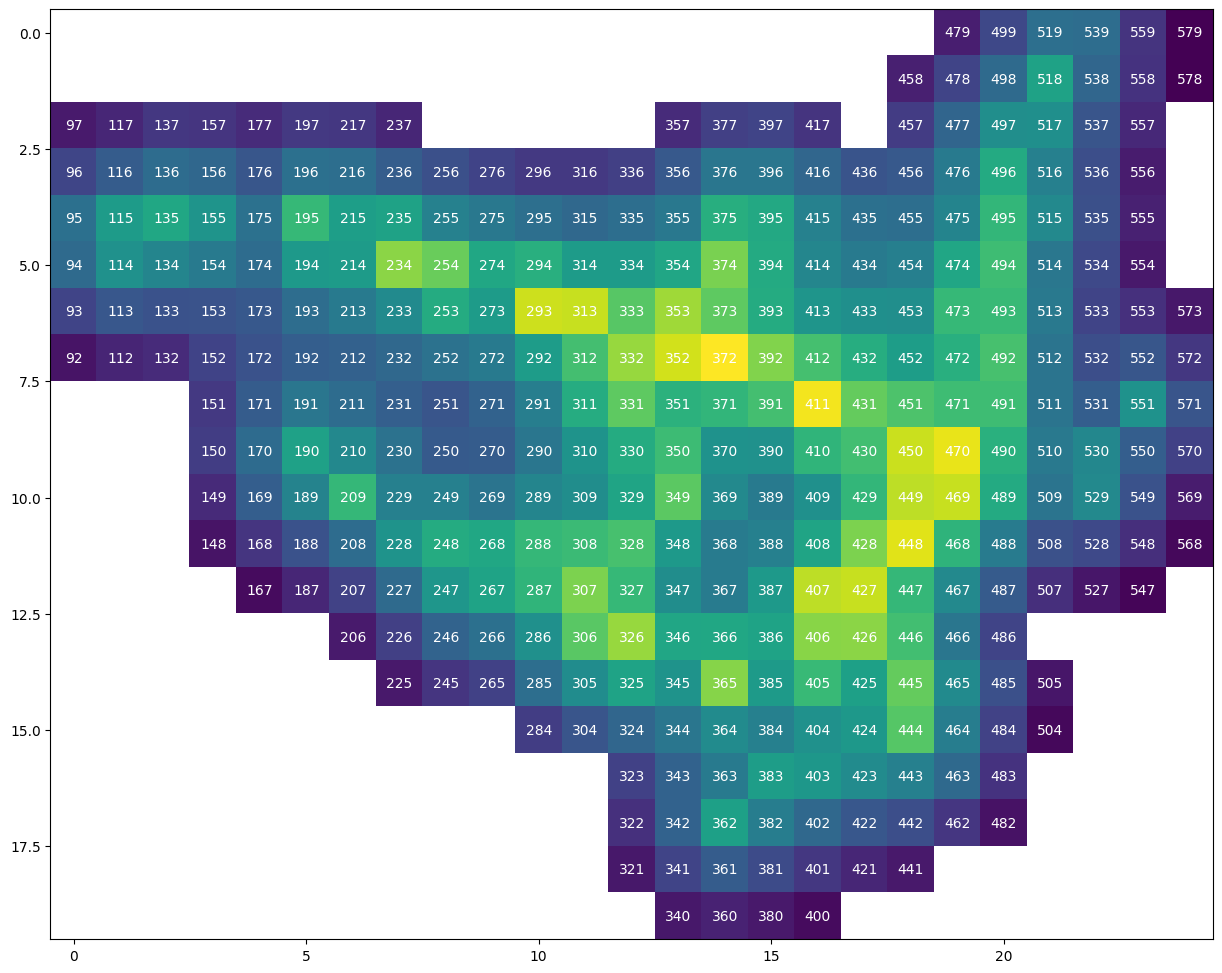

In [34]:
centr_id_matr, acc_matr_after = build_accessibility_matrix(g)
plot_acc(centr_id_matr, acc_matr_after)